In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
def detect_and_describe(image):
    """
    Детектирование ключевых точек и вычисление дескрипторов с помощью SIFT.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

def match_keypoints(desc1, desc2, ratio=0.75):
    """
    Сопоставление дескрипторов двух изображений с использованием Lowe's ratio test.
    """
    bf = cv2.BFMatcher()
    raw_matches = bf.knnMatch(desc1, desc2, k=2)

    good_matches = []
    for m, n in raw_matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

def compute_homography(kp1, kp2, matches):
    """
    Вычисление гомографии по сопоставленным ключевым точкам.
    """
    if len(matches) >= 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        H, status = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, status
    else:
        return None, None

def stitch_images(image1, image2, H):
    """
    Корректная сшивка двух изображений с расчётом размера выходной панорамы.
    """
    # Размеры исходных изображений
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]

    # Углы первого изображения
    corners_image1 = np.float32([
        [0, 0],
        [0, h1],
        [w1, h1],
        [w1, 0]
    ]).reshape(-1, 1, 2)

    # Трансформируем углы первого изображения с помощью гомографии
    warped_corners = cv2.perspectiveTransform(corners_image1, H)

    # Углы второго изображения
    corners_image2 = np.float32([
        [0, 0],
        [0, h2],
        [w2, h2],
        [w2, 0]
    ]).reshape(-1, 1, 2)

    # Объединяем все углы для расчета размера финальной картинки
    all_corners = np.concatenate((warped_corners, corners_image2), axis=0)

    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())

    translation_dist = [-xmin, -ymin]

    # Корректируем матрицу гомографии для переноса в положительную область
    translation_matrix = np.array([
        [1, 0, translation_dist[0]],
        [0, 1, translation_dist[1]],
        [0, 0, 1]
    ])

    H_translation = translation_matrix @ H

    # Варьируем размеры результирующего изображения
    result = cv2.warpPerspective(image1, H_translation, (xmax - xmin, ymax - ymin))
    result[translation_dist[1]:h2+translation_dist[1], translation_dist[0]:w2+translation_dist[0]] = image2

    return result


def plot_matches(image1, image2, kp1, kp2, matches):
    """
    Визуализация сопоставленных ключевых точек.
    """
    matched_img = cv2.drawMatches(image1, kp1, image2, kp2, matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(20,10))
    plt.imshow(matched_img)
    plt.axis('off')
    plt.show()



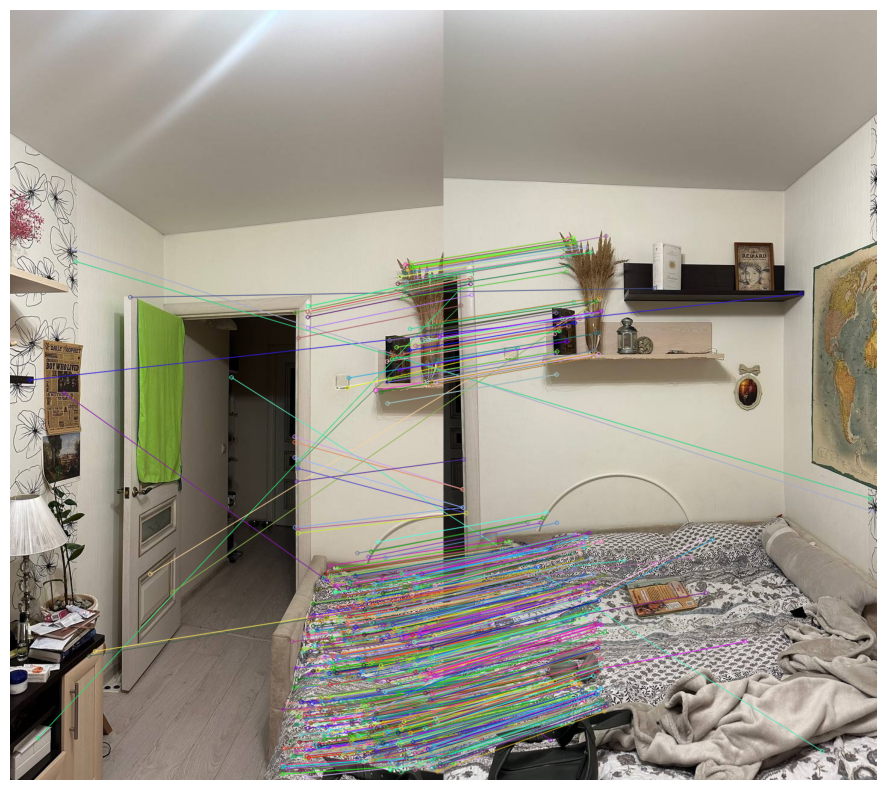

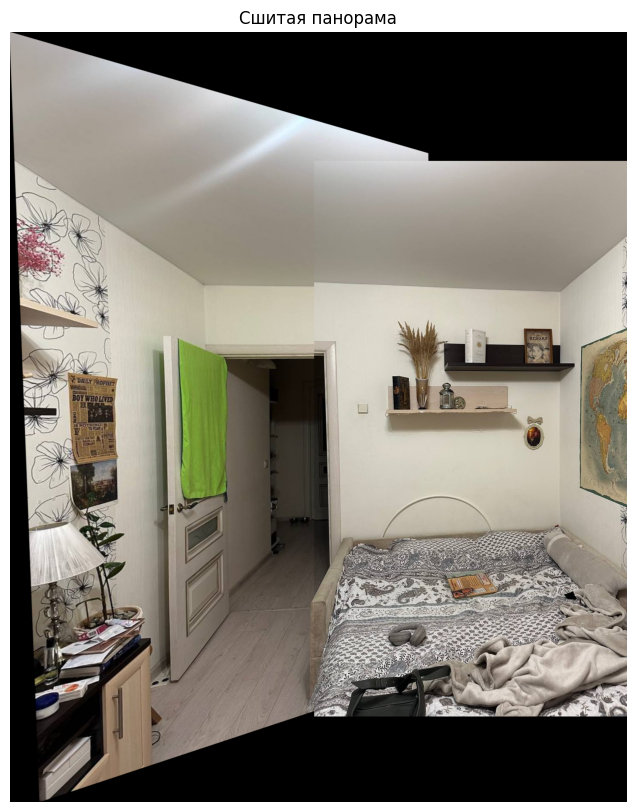

In [ ]:
image1 = cv2.imread('image_1.jpg')
image2 = cv2.imread('image_2.jpg')
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# 1. Детектирование и описание признаков
keypoints1, descriptors1 = detect_and_describe(image1)
keypoints2, descriptors2 = detect_and_describe(image2)

# 2. Поиск совпадений
good_matches = match_keypoints(descriptors1, descriptors2)

# 3. Отобразить совпадения
plot_matches(image1, image2, keypoints1, keypoints2, good_matches)

# 4. Построение гомографии
H, status = compute_homography(keypoints1, keypoints2, good_matches)

if H is not None:
    # 5. Сшивание изображений
    result = stitch_images(image1, image2, H)

    # 6. Отображение панорамы
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.axis('off')
    plt.title('Сшитая панорама')
    plt.show()
else:
    print("Не удалось вычислить гомографию — недостаточно совпадений.")
